### Setup

In [12]:
!apt update
!apt install -y xvfb
!pip install -U pyvirtualdisplay

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (95.2 kB/s)
Reading package li

In [13]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-05-07 18:18:07--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  18.68M   735KB/s    in 27s     

2022-05-07 18:18:34 (715 KB/s) - ‘Roms.rar.1’ saved [19583716/19583716]

mkdir: cannot create directory ‘/content/ROM/’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar


Would you like to replace the existing file /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin
  2048 bytes, modified on 2017-11-20 22:54
with a new one
  2048 bytes, modified on 2017-11-20 22:54

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin          0%

In [14]:
import gym
import tensorflow as tf
from tensorflow import keras
from keras import layers
assert tf.__version__ >= "2.0"
import sklearn
import gym
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from collections import deque

In [15]:
env = gym.make('Breakout-v0')

In [16]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [17]:
env.observation_space.shape

(210, 160, 3)

In [18]:
env.action_space.n

4

In [19]:
env.render()

True

### CNN Double Deep Q-Network

In [20]:
keras.backend.clear_session()
tf.random.set_seed(2022)
np.random.seed(2022)

env = gym.make('Breakout-v0')

In [21]:
env.observation_space.shape


(210, 160, 3)

In [22]:
# El input lo hemos obtenido antes
input_shape = [210, 160, 3] 

# El número de outputs debe coincidir con el número de posibles acciones
n_outputs = 4 

# Creamos la estructura de la red de prediccion
model_predict = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, input_shape = input_shape, activation="ReLU"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(64, kernel_size=3,activation="ReLU"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(128, kernel_size=3,activation="ReLU"),
    keras.layers.MaxPooling2D(pool_size=(4,4)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),          
    keras.layers.Dense(128, activation="ReLU"),
    keras.layers.Dense(n_outputs, activation="softmax")
])

# Creamos la estructura de la red de target, que será la misma 
# que para predecir pero la actualización se hará cada C episodios
model_target = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, input_shape = input_shape, activation="ReLU"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(64, kernel_size=3,activation="ReLU"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(128, kernel_size=3,activation="ReLU"),
    keras.layers.MaxPooling2D(pool_size=(4,4)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),          
    keras.layers.Dense(128, activation="ReLU"),
    keras.layers.Dense(n_outputs, activation="softmax")
])

# Establecemos los mismos pesos en ambas redes
weights = model_predict.get_weights()
model_target.set_weights(weights)


# Establecemos Adam como optimizador con un learning rate
optimizer = keras.optimizers.Adam(lr=1e-3)

# Definimos la función de pérdida
loss_fn = keras.losses.mean_squared_error

# Printeamos la estructura de la red
model_predict.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 208, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 104, 79, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 77, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 9, 128)       0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model_predict.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [24]:
from collections import deque

replay_memory = deque(maxlen=200000)

In [25]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [26]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [27]:
def training_step(batch_size,episode):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model_predict.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (model_target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_predict(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_predict.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_predict.trainable_variables))
    if episode % 20 == 0: 
        model_target.set_weights(model_predict.get_weights())

In [28]:
env.seed(2022)
np.random.seed(2022)
tf.random.set_seed(2022)

In [29]:
best_score = 0
rewards = []
best_weights = []
batch_size = 32
discount_rate = 0.9

for episode in range(300):
    episode_rewards = 0
    obs = env.reset() 
    for step in range(500):
        epsilon = max(1 - episode / 250, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        episode_rewards += reward    
        if done:
            break
    rewards.append(episode_rewards) 
    if episode_rewards > best_score: 
        best_weights = model_predict.get_weights()
        best_score = episode_rewards

    print("Episode: {}, Episode_Rewards: {}, eps: {}, best_score: {}".format(episode, episode_rewards, epsilon, best_score)) 
    if episode > 50:
        training_step(batch_size,episode)    

model_predict.set_weights(best_weights)

Episode: 0, Episode_Rewards: 3.0, eps: 1.0, best_score: 3.0
Episode: 1, Episode_Rewards: 0.0, eps: 0.996, best_score: 3.0
Episode: 2, Episode_Rewards: 0.0, eps: 0.992, best_score: 3.0
Episode: 3, Episode_Rewards: 1.0, eps: 0.988, best_score: 3.0
Episode: 4, Episode_Rewards: 2.0, eps: 0.984, best_score: 3.0
Episode: 5, Episode_Rewards: 1.0, eps: 0.98, best_score: 3.0
Episode: 6, Episode_Rewards: 1.0, eps: 0.976, best_score: 3.0
Episode: 7, Episode_Rewards: 0.0, eps: 0.972, best_score: 3.0
Episode: 8, Episode_Rewards: 0.0, eps: 0.968, best_score: 3.0
Episode: 9, Episode_Rewards: 1.0, eps: 0.964, best_score: 3.0
Episode: 10, Episode_Rewards: 2.0, eps: 0.96, best_score: 3.0
Episode: 11, Episode_Rewards: 1.0, eps: 0.956, best_score: 3.0
Episode: 12, Episode_Rewards: 0.0, eps: 0.952, best_score: 3.0
Episode: 13, Episode_Rewards: 0.0, eps: 0.948, best_score: 3.0
Episode: 14, Episode_Rewards: 2.0, eps: 0.944, best_score: 3.0
Episode: 15, Episode_Rewards: 2.0, eps: 0.94, best_score: 3.0
Episode

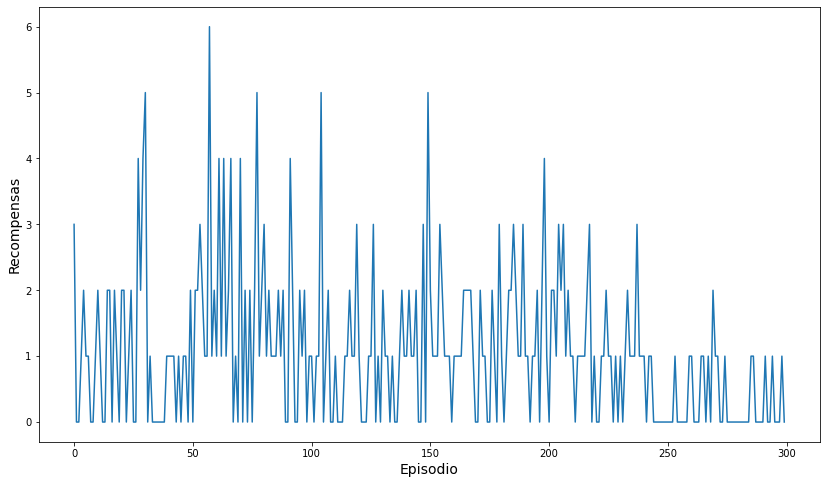

In [30]:
plt.figure(figsize=(14, 8))
plt.plot(rewards)
plt.xlabel("Episodio", fontsize=14)
plt.ylabel("Recompensas", fontsize=14)
plt.show()